In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Pandas read_csv:

In [25]:
store_sales = pd.read_csv('store_sale.csv')
store_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


Check null value

In [26]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


Disregard the columns representing the Store ID and Item ID

In [27]:
store_sales = store_sales.drop(['store','item'], axis=1)

Convert date object to a DateTime datatype so that it can be used for further calculations

In [28]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

Train the models to predict the sales in the next month. Convert date to a period of ‘Month’ and then sum the number of items sold in each month

In [29]:
store_sales['date'] = store_sales['date'].dt.to_period('M')
monthly_sales = store_sales.groupby('date').sum().reset_index()

Convert the resulting ‘date’ column to timestamp datatype

In [30]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


Visualize the monthly sales of the items

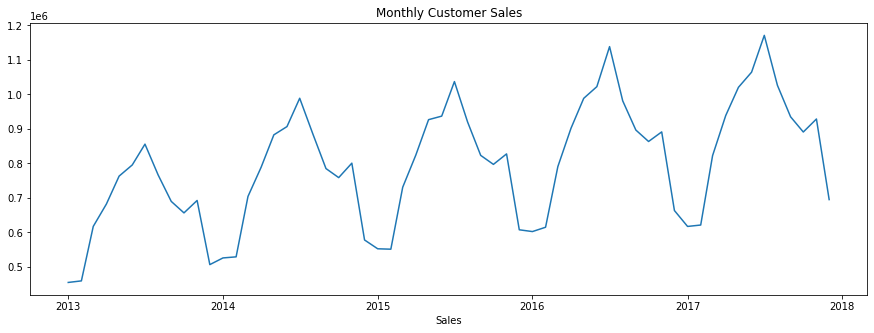

In [31]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date')
plt.xlabel('Sales')
plt.title("Monthly Customer Sales")
plt.show()

Make the sale data stationery

In [32]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


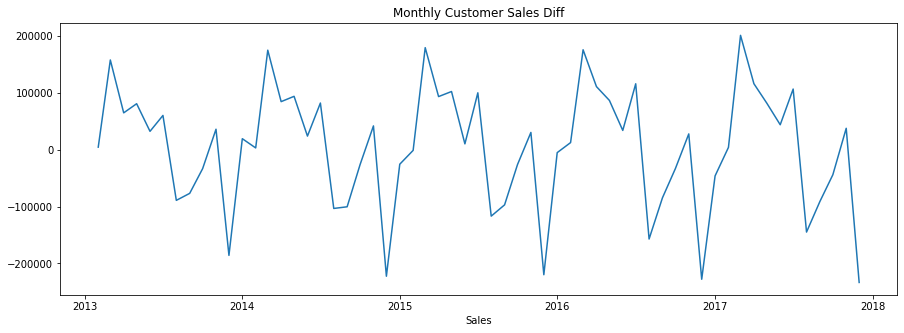

In [33]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales_diff'])
plt.xlabel('Date')
plt.xlabel('Sales')
plt.title("Monthly Customer Sales Diff")
plt.show()

Train the models to predict the sale of the items in the next month by looking at the sale of items in a specific number of previous months, we need to prepare a supervised dataset to feed into the machine learning model

In [34]:
supverised_data = monthly_sales.drop(['date','sales'], axis=1)

Prepare the supervised data such that the previous 12-month sale data is advertised as the input features and the 13th-month sale data is used as the output for the supervised learning models

In [35]:
for i in range(1,13):
    col_name = 'month_' + str(i)
    supverised_data[col_name] = supverised_data['sales_diff'].shift(i)

In [36]:
supverised_data = supverised_data.dropna().reset_index(drop=True)
supverised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


Split this data into training and test data

In [37]:
train_data = supverised_data[:-12]
test_data = supverised_data[-12:]
print('Train Data Shape:', train_data.shape)
print('Test Data Shape:', test_data.shape)

Train Data Shape: (35, 13)
Test Data Shape: (12, 13)


Scale the feature values to restrict them to a range of (-1,1) using MinMaxScaler()

In [38]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)

MinMaxScaler(feature_range=(-1, 1))

In [39]:
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [40]:
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)


X_train Shape: (35, 12)
y_train Shape: (35,)
X_test Shape: (12, 12)
y_test Shape: (12,)


Make a prediction data frame to merge the predicted sale prices of all the trained algorithms

In [41]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8684\3984850881.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)


Extract the actual monthly sale values of the last 13 months since they correspond to test data set. These values will later be used to find the predicted sale prices from the predicted output of sale difference via trained models

In [42]:
act_sales = monthly_sales['sales'][-13:].to_list()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8684\2173393283.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  act_sales = monthly_sales['sales'][-13:].to_list()


#### Linear Regression

Use the ‘predict’ function of the linear regression model to get the predicted outputs using the test data

In [43]:
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)
linreg_pred = linreg_model.predict(X_test)

Transform the predicted values back to their original scale

In [44]:
linreg_pred = linreg_pred.reshape(-1,1)
linreg_pred_test_set = np.concatenate([linreg_pred,X_test], axis=1)
linreg_pred_test_set = scaler.inverse_transform(linreg_pred_test_set)

Calculate the predicted sale values from the difference values and append that to the predicted data frame which was created earlier

In [45]:
result_list = []
for index in range(0, len(linreg_pred_test_set)):
    result_list.append(linreg_pred_test_set[index][0] + act_sales[index])
linreg_pred_series = pd.Series(result_list,name='linreg_pred')
predict_df = predict_df.merge(linreg_pred_series, left_index=True, right_index=True)

Evaluate various metrics for the trained Linear Regression model by comparing the predicted sale values with the actual sale values

In [46]:
linreg_rmse = np.sqrt(mean_squared_error(predict_df['linreg_pred'], monthly_sales['sales'][-12:]))
linreg_mae = mean_absolute_error(predict_df['linreg_pred'], monthly_sales['sales'][-12:])
linreg_r2 = r2_score(predict_df['linreg_pred'], monthly_sales['sales'][-12:])
print('Linear Regression RMSE: ', linreg_rmse)
print('Linear Regression MAE: ', linreg_mae)
print('Linear Regression R2 Score: ', linreg_r2)

Linear Regression RMSE:  16221.272385416896
Linear Regression MAE:  12433.184266490784
Linear Regression R2 Score:  0.9906152516380968


C:\Users\Administrator\AppData\Local\Temp\ipykernel_8684\3553433356.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  linreg_rmse = np.sqrt(mean_squared_error(predict_df['linreg_pred'], monthly_sales['sales'][-12:]))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_8684\3553433356.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  linreg_mae = mean_absolute_error(predict_df['linreg_pred'], monthly_sales['sales'][-12:])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_868

Visualize the predictions against the actual values

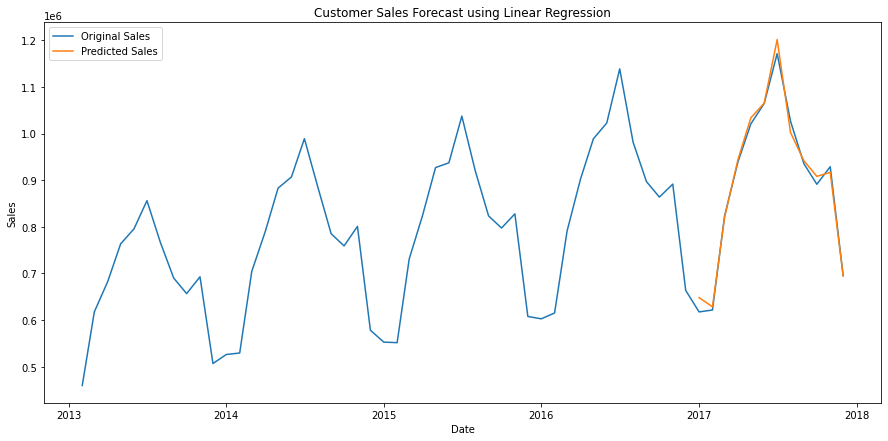

In [47]:
plt.figure(figsize=(15,7))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.plot(predict_df['date'], predict_df['linreg_pred'])
plt.title("Customer Sales Forecast using Linear Regression")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()